<a href="https://colab.research.google.com/github/salim4n/kaggle_competition/blob/main/TensorScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectif : Créer un mini tensorflow




In [129]:
import pandas as pd
import numpy as np

In [130]:
class Boite():

  def __init__(self):
    pass

  def forward(self, inputs):
    self.inputs = inputs
    self.output = self.operation()
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape, f"La derivee_output reçue a un shape {derivee_output.shape} et different du shape de output : {self.output.shape}"

    self.derivee_inputs = self.gradient(derivee_output)
    assert self.derivee_inputs.shape == self.inputs.shape, f"La derivee_input calculée a un shape {self.derivee_inputs.shape } et different du shape de inputs : {self.inputs.shape}"

    return self.derivee_inputs


  def operation(self):
    pass

  def gradient(self, derivee_output):
    pass



In [131]:
class BoiteParam():

  def __init__(self, param):
    self.param = param

  def forward(self, inputs):
    self.inputs = inputs
    self.output = self.operation()
    return self.output

  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape, f"La derivee_output reçue a un shape {derivee_output.shape} et different du shape de output : {self.output}"

    self.derivee_inputs = self.gradient(derivee_output)
    assert self.derivee_inputs.shape == self.inputs.shape, f"La derivee_input calculée a un shape {self.derivee_inputs.shape } et different du shape de inputs : {self.inputs.shape}"

    self.derivee_param = self.gradient_param(derivee_output)
    assert self.derivee_param.shape == self.param.shape, f"La derivee de param a un shape {self.derivee_param.shape} et different du shape de param : {self.param.shape}"

    return self.derivee_inputs


  def operation(self):
    pass

  def gradient(self, derivee_output):
    pass


  def gradient_param(self, derivee_output):
    pass

## La classe Dot

In [132]:
class Dot(BoiteParam):

  def __init__(self, weights):
    super().__init__(weights)

  def operation(self):
    return np.dot(self.inputs, self.param)

  def gradient(self, derivee_output):
    return np.dot( derivee_output, self.param.T)

  def gradient_param(self, derivee_output):
    return np.dot(self.inputs.T, derivee_output)

  def __repr__(self):
    return "DotProduct"

## La classe ADD

In [133]:
class Add(BoiteParam):

  def __init__(self, biais):
    super().__init__(biais)

  def operation(self):
    return self.inputs + self.param

  def gradient(self, derivee_output):
    return np.ones_like(self.inputs) * derivee_output

  def gradient_param(self, derivee_output):
    r =  np.ones_like(self.param) * derivee_output
    return r.sum(axis=0).reshape(1, self.param.shape[1])

  def __repr__(self):
    return "AddBiais"

## La classe Sigmoid

In [134]:
class Sigmoid(Boite):

  def __init__(self):
    super().__init__()

  def operation(self):
    return 1 / (1 + np.exp(-1 * self.inputs))

  def gradient(self, derivee_output):
    return self.output * (1 - self.output) * derivee_output

  def __repr__(self):
    return "Sigmoid"

## La classe Loss

In [135]:
class Loss():

  def __init__(self):
    pass

  def forward(self, prediction, target):
    assert prediction.shape == target.shape, f"Prediction shape {prediction.shape}  Target shape {target.shape}"
    self.prediction = prediction
    self.target = target
    loss = np.mean((self.target - self.prediction) ** 2)
    return loss

  def backward(self):

    self.loss_derivee = -2 * (self.target - self.prediction)
    assert self.loss_derivee.shape == self.prediction.shape, f"La derivee du loss un shape {self.loss_derivee.shape } et different du shape de Prediction : {self.prediction.shape}"

    return self.loss_derivee

## La classe Dense

In [136]:
class Dense():

  def __init__(self, neurons, activation=None):
    self.neurons = neurons
    self.activation = activation
    self.params = []
    self.suite = []
    self.initialisation = True


  def build(self, inputs):
    # weights initialization
    np.random.seed(42)

    self.weights = np.random.randn(inputs.shape[1], self.neurons)
    self.biais = np.random.randn(1, self.neurons)

    self.params.append(self.weights)
    self.params.append(self.biais)

    # construction de la suite d'opération
    self.suite = [Dot(weights=self.params[0]), Add(biais=self.params[1])]
    if self.activation:
      self.suite.append(self.activation)



  def forward(self, inputs):
    if self.initialisation:
      self.build(inputs)
      self.initialisation = False

    for boite in self.suite:
      inputs = boite.forward(inputs)

    self.output = inputs

    return self.output


  def backward(self, derivee_output):
    assert derivee_output.shape == self.output.shape

    for boite in reversed(self.suite):
      derivee_output = boite.backward(derivee_output)

    derivee_inputs = derivee_output

    self.get_layer_gradients()

    return derivee_inputs

  def get_layer_gradients(self):

    self.derivee_params = []

    for boite in self.suite:
      if issubclass(boite.__class__, BoiteParam):
        self.derivee_params.append(boite.derivee_param)



  def __repr__(self):
    r = f"DenseLayer(neurons={self.neurons})"
    if self.activation:
      r += " avec Sigmoid"

    return r

## La classe Modèle

In [137]:
from copy import deepcopy

In [138]:
class Model():

  def __init__(self, layers):
    self.layers = layers
    self.compiled = False


  def forward(self, inputs):


    for layer in self.layers:

      inputs = layer.forward(inputs)
    self.output = inputs
    return self.output


  def backward(self, loss_derivee):

    assert loss_derivee.shape == self.output.shape

    for layer in reversed(self.layers):
      loss_derivee = layer.backward(loss_derivee)

    return None

  def get_params(self):
    for layer in self.layers:
      yield from layer.params


  def get_derivee_params(self):
    for layer in self.layers:
      yield from layer.derivee_params


  def update(self):

    for (param, derivee_param) in zip(self.get_params(), self.get_derivee_params()):
      assert param.shape == derivee_param.shape
      param -=   self.learning_rate * derivee_param


  def compile(self, loss, learning_rate):
    self.loss = loss
    self.learning_rate = learning_rate
    self.compiled = True


  def fit(self, X, Y, epochs, validation_data=None):

    if validation_data:
      assert len(validation_data) == 2
      assert validation_data[0].shape[1] == X.shape[1]
      assert validation_data[1].shape[1] == Y.shape[1]

    self.history = {"loss":[]}
    if validation_data:
      self.history['val_loss'] = []


    if not self.compiled:
      raise NotImplementedError("Pas de loss et de learning_rate: Compilez")

    for epoch in range(epochs):
      # forward pass
      predictions = model.forward(X)
      loss = self.loss.forward(predictions, Y)
      self.history['loss'].append(loss)


      # val loss
      if validation_data:
        val_preds = model.forward(validation_data[0])
        val_loss = self.loss.forward(val_preds, validation_data[1])
        self.history['val_loss'].append(val_loss)

      log = f'Epoch {epoch+1} .............. loss : {loss}'
      if validation_data:
        log += f"  ....val_loss : {val_loss}"
      print(log)



      # backward pass
      loss_derivee = self.loss.backward()
      self.backward(loss_derivee)

      # update
      self.update()

    return self.history

  def save_model(self, file):
    model_save = deepcopy(self)

    import pickle
    with open(file, "wb") as f:
      pickle.dump(model_save, f)


  def __repr__(self):

    r = "Layers ................."
    for layer in self.layers:
      r += f" \n {str(layer)}"

    return r

## Test sur le Boston Dataset

In [139]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
data = data
target = target
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
data = data
target = target

X = data
Y = target.reshape((506, 1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
X_train.shape, y_train.shape
X_test

array([[-0.4056463 , -0.49882807, -1.11854752, ..., -0.72620097,
         0.18418254, -0.72377323],
       [ 0.7056307 , -0.49882807,  1.00060803, ...,  0.78128376,
         0.08244389, -0.41932101],
       [-0.39994626, -0.49882807,  0.40022816, ..., -0.95460774,
         0.39226392, -0.28447232],
       ...,
       [-0.37143398, -0.49882807, -0.16877794, ..., -0.04098064,
         0.42033751, -0.35815253],
       [-0.40185719, -0.49882807,  2.07729878, ...,  0.27878885,
         0.23100928,  0.69978415],
       [-0.40470175,  0.8889692 , -1.26971205, ..., -0.04098064,
         0.42774893, -0.84471999]])

In [141]:
X_test.shape, y_test.shape

((127, 13), (127, 1))

## Regression lineaire simple

In [142]:
model = Model([Dense(neurons=1)])
mse = Loss()
model.compile(loss=mse, learning_rate=0.001)
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1 .............. loss : 712.1743316753176  ....val_loss : 671.7547143671588
Epoch 2 .............. loss : 384.0837028693358  ....val_loss : 383.82786822291087
Epoch 3 .............. loss : 247.75414344252928  ....val_loss : 229.1941295737599
Epoch 4 .............. loss : 148.3806303920543  ....val_loss : 144.19534190777878
Epoch 5 .............. loss : 103.89520896898965  ....val_loss : 96.47739842280843
Epoch 6 .............. loss : 71.33479105168065  ....val_loss : 69.15302180485378
Epoch 7 .............. loss : 55.97937743045081  ....val_loss : 53.20253156199875
Epoch 8 .............. loss : 44.69041961018085  ....val_loss : 43.70966230146516
Epoch 9 .............. loss : 39.11541183660613  ....val_loss : 37.94536623883121
Epoch 10 .............. loss : 35.00552004305203  ....val_loss : 34.3691118394618
Epoch 11 .............. loss : 32.86685286102087  ....val_loss : 32.09754754821056
Epoch 12 .............. loss : 31.27998033095609  ....val_loss : 30.616578716256143
Epoch 13 

In [143]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
  plt.plot(list(range(len(history['loss']))), history['loss'])
  plt.plot(list(range(len(history['val_loss']))), history['val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.title("Learning Curve")
  plt.show()


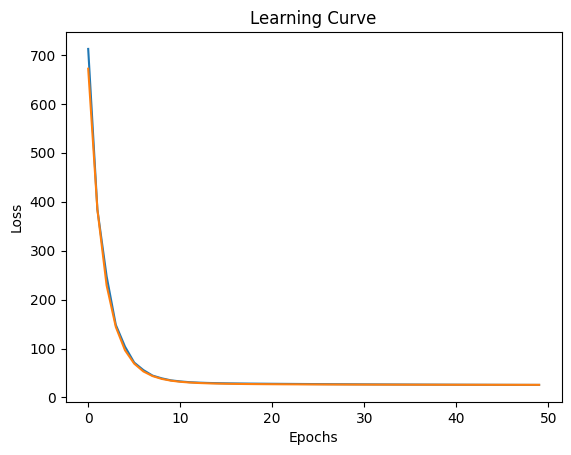

In [144]:
plot_learning_curve(h)

## Réseau de neurones simple

In [145]:
sigmoid = Sigmoid()
model = Model([ Dense(neurons=3, activation=sigmoid),
                Dense(neurons=1)
                ])
model

Layers ................. 
 DenseLayer(neurons=3) avec Sigmoid 
 DenseLayer(neurons=1)

In [146]:
mse = Loss()
model.compile(loss=mse, learning_rate=0.0001)
h = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1 .............. loss : 507.9248956497336  ....val_loss : 492.311693850643
Epoch 2 .............. loss : 466.24520089721494  ....val_loss : 451.5607557083814
Epoch 3 .............. loss : 427.7318622051442  ....val_loss : 413.9124130384742
Epoch 4 .............. loss : 391.9445763802112  ....val_loss : 378.9220233229542
Epoch 5 .............. loss : 358.64849568841305  ....val_loss : 346.36124271593445
Epoch 6 .............. loss : 327.7617822429383  ....val_loss : 316.1600493240994
Epoch 7 .............. loss : 299.2676236516309  ....val_loss : 288.3099264728872
Epoch 8 .............. loss : 273.13622523629294  ....val_loss : 262.78193463964385
Epoch 9 .............. loss : 249.29517625915642  ....val_loss : 239.50103731811706
Epoch 10 .............. loss : 227.63791951268425  ....val_loss : 218.36067475205962
Epoch 11 .............. loss : 208.03992319108744  ....val_loss : 199.24113995526798
Epoch 12 .............. loss : 190.36761824850086  ....val_loss : 182.0169604282577
Ep

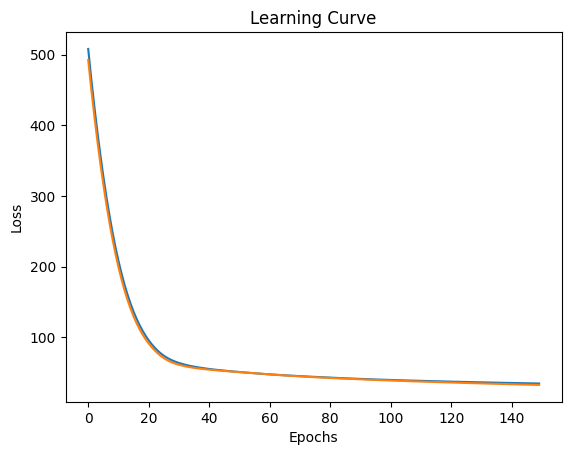

In [147]:
plot_learning_curve(h)

## Réseau de neurones profond

In [148]:
sigmoid = Sigmoid()
model = Model([ Dense(neurons=13, activation=sigmoid),
                Dense(neurons=1)
                ])
model

Layers ................. 
 DenseLayer(neurons=13) avec Sigmoid 
 DenseLayer(neurons=1)

In [149]:
mse = Loss()
model.compile(loss=mse, learning_rate=0.0001)
h = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1 .............. loss : 609.4535263872165  ....val_loss : 594.285047596059
Epoch 2 .............. loss : 494.7172454598782  ....val_loss : 479.0339597155269
Epoch 3 .............. loss : 403.8643944989146  ....val_loss : 388.125852443045
Epoch 4 .............. loss : 331.0559254119759  ....val_loss : 315.67394558965
Epoch 5 .............. loss : 272.44802631944543  ....val_loss : 257.80096535791387
Epoch 6 .............. loss : 225.32104126553727  ....val_loss : 211.7461595039089
Epoch 7 .............. loss : 187.60578616146617  ....val_loss : 175.37471756759948
Epoch 8 .............. loss : 157.62037539699094  ....val_loss : 146.91491099254424
Epoch 9 .............. loss : 133.9379615740088  ....val_loss : 124.84238208175846
Epoch 10 .............. loss : 115.33306807953525  ....val_loss : 107.84460906755527
Epoch 11 .............. loss : 100.76383198721742  ....val_loss : 94.8136613248053
Epoch 12 .............. loss : 89.36281102397759  ....val_loss : 84.83959359519152
Epoch 1

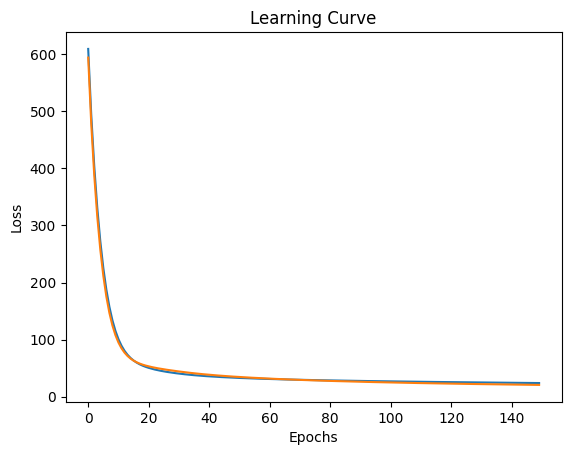

In [150]:
plot_learning_curve(h)

## Sauvegarder le modèle

In [152]:
model
model.save_model('model.file')

In [153]:
import pickle

def load_model(file):
  with open(file, 'rb') as f:
    model_load = pickle.load(f)
  return model_load

In [154]:
model_loaded = load_model("model.file")
model_loaded

Layers ................. 
 DenseLayer(neurons=13) avec Sigmoid 
 DenseLayer(neurons=1)